<a href="https://colab.research.google.com/github/clohaa/242project/blob/main/3.1%20Modelling_clustering_and_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
file_path1 = 'drive/MyDrive/242 Project/Clean dataset/model_data.csv'
with open(file_path1, 'r') as f1:
  df = pd.read_csv(f1)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

df.head()

,continent,location,date,new_cases,new_deaths,reproduction_rate,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand
0,Asia,Afghanistan,2021-03-01,19,1.0,0.94,0.0,12.04,39835428,54.422,2.581,1803.987,38.7,597.029,9.59,5.31,38.93,0.5
1,Asia,Afghanistan,2021-03-02,26,2.0,0.96,0.0,12.04,39835428,54.422,2.581,1803.987,38.7,597.029,9.59,5.31,38.93,0.5
2,Asia,Afghanistan,2021-03-03,11,0.0,0.97,0.0,12.04,39835428,54.422,2.581,1803.987,38.7,597.029,9.59,5.31,38.93,0.5
3,Asia,Afghanistan,2021-03-04,5,0.0,0.99,0.0,12.04,39835428,54.422,2.581,1803.987,38.7,597.029,9.59,5.31,38.93,0.5
4,Asia,Afghanistan,2021-03-05,52,3.0,1.01,0.0,12.04,39835428,54.422,2.581,1803.987,38.7,597.029,9.59,5.31,38.93,0.5


In [ ]:
file_path2 = 'drive/MyDrive/242 Project/Clean dataset/cluster_data.csv'
with open(file_path2, 'r') as f2:
  df2 = pd.read_csv(f2)
df2.drop(['Unnamed: 0'], axis = 1, inplace = True)

df2.head()

,reproduction_rate,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,mortality_rate
0,0.72,1.08,27.78,39835428,54.422,2.581,1803.987,38.7,597.029,9.59,5.31,38.93,0.50,18.302803
1,1.15,31.80,45.37,2872934,104.871,13.188,11803.431,1.1,304.195,10.08,7.10,51.20,2.89,103.552675
2,1.16,10.98,39.81,44616626,17.348,6.211,13913.839,0.5,278.364,6.73,0.70,30.40,1.90,13.358249
3,0.62,5.83,55.09,33933611,23.890,2.405,5819.495,3.3,276.045,3.94,3.01,29.32,1.45,5.077562
4,1.05,58.93,42.59,45605823,16.177,11.198,18933.907,0.6,191.032,5.50,16.20,27.70,5.00,254.756942


In [ ]:
file_path3 = 'drive/MyDrive/242 Project/Clean dataset/original_data.csv'
with open(file_path3, 'r') as f3:
  df3 = pd.read_csv(f3)

df3.head()

,Unnamed: 0,iso_code,continent,location,date,new_cases,total_deaths,new_deaths,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index
0,371,AFG,Asia,Afghanistan,2021-03-01,19.0,2444.0,1.0,0.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.04,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,0.5,64.83,0.511
1,372,AFG,Asia,Afghanistan,2021-03-02,26.0,2446.0,2.0,0.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.04,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,0.5,64.83,0.511
2,373,AFG,Asia,Afghanistan,2021-03-03,11.0,2446.0,0.0,0.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.04,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,0.5,64.83,0.511
3,374,AFG,Asia,Afghanistan,2021-03-04,5.0,2446.0,0.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.04,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,0.5,64.83,0.511
4,375,AFG,Asia,Afghanistan,2021-03-05,52.0,2449.0,3.0,1.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.04,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,0.5,64.83,0.511


**Cluster-then-Predict**

Pre-processing: Standardization

First, center the data (substract the mean to each column)
=> mean becomes 0 for each column

Then, scale the data, by dividing by the standard deviation
=> std becomes 1 for each column

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
df2_scaled = scaler.fit_transform(df2)

df2_scaled = pd.DataFrame(df2_scaled, columns=df2.columns)
df2_scaled

,reproduction_rate,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,mortality_rate
0,-0.967697,-1.551833,-1.155995,-0.086630,-0.489343,-1.161135,-1.106613,2.236470,2.854116,0.669492,-0.578067,0.457035,-1.017943,-0.988238
1,0.667862,-0.301738,-0.007284,-0.349852,-0.201932,0.496597,-0.447307,-0.433942,0.403594,0.824907,-0.410897,1.466356,-0.093956,-0.186264
2,0.705898,-1.148970,-0.370378,-0.052582,-0.700556,-0.593814,-0.308159,-0.476555,0.187433,-0.237622,-1.008601,-0.244636,-0.476695,-1.034753
3,-1.348059,-1.358540,0.627479,-0.128659,-0.663286,-1.188641,-0.841854,-0.277694,0.168027,-1.122535,-0.792867,-0.333476,-0.650668,-1.112652
4,0.287499,0.802268,-0.188831,-0.045538,-0.707227,0.185587,0.022836,-0.469453,-0.543387,-0.627745,0.438965,-0.466736,0.721782,1.236165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.021245,-0.281392,1.927697,-0.165894,-0.592853,-0.530831,-0.121487,-0.334512,-0.427754,-0.320087,-0.011649,-0.930678,-0.901962,-0.996687
107,1.010188,-0.304180,1.413749,0.328780,0.956032,-0.447061,-0.818619,-0.370023,-0.087876,-0.469159,-0.980584,1.030382,-0.206071,-0.942266
108,-0.549298,-1.566889,-1.458356,-0.153177,-0.494550,-1.107841,-1.128031,0.823140,2.000332,-0.675321,-0.364201,-0.343347,-0.940622,-1.101242
109,0.097318,-1.474516,-0.068017,-0.235571,-0.668385,-1.176919,-0.982310,3.571677,-0.179643,-1.122535,-0.784462,-0.713513,-0.438035,-0.978244


Hierarchical Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',
                                        distance_threshold=0)

agglomerative.fit(df2)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

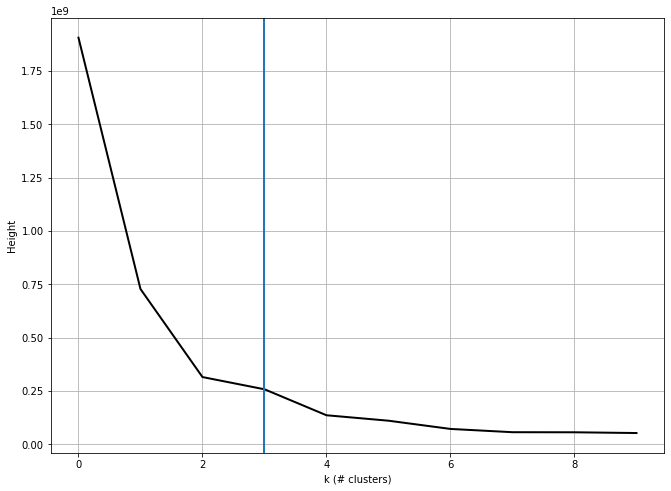

In [ ]:
reversed_distances = agglomerative.distances_[::-1]
plt.figure(figsize=(11,8))
plt.plot(reversed_distances[:10], linewidth=2, color='black')
plt.xlabel('k (# clusters)')
plt.ylabel('Height')
plt.grid(axis='both')
plt.axvline(x=3, linewidth=2)
plt.show()

After visual inspection of the dendrogram and scree plot, we can now construct the clusters with our selected `k`. We can refit an agglomerative object with the desired parameter. We can make use of `n_clusters`, or also use `distance_threshold`.

In [ ]:
new_agglomerative = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward',
                                            distance_threshold=None)
new_agglomerative.fit(df2_scaled)

AgglomerativeClustering(n_clusters=3)

In [ ]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    
    
    dendrogram(linkage_matrix, **kwargs)  

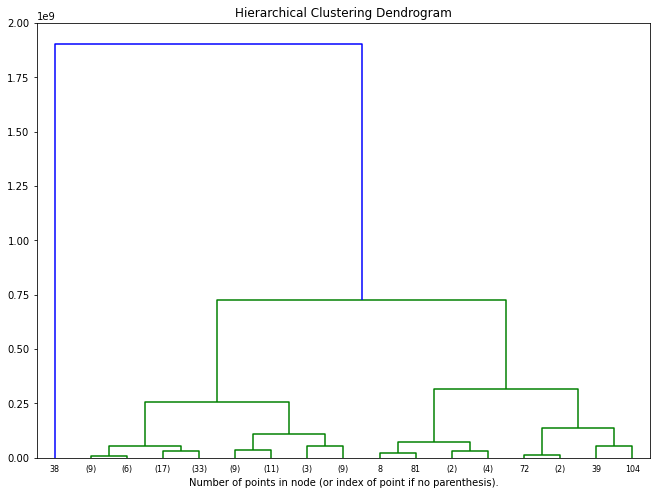

In [ ]:
plt.figure(figsize=(11,8))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(agglomerative, truncate_mode='level', p=4, leaf_font_size=8)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
new_df2_scaled = df2_scaled.copy()
new_df2_scaled['Cluster'] = new_agglomerative.labels_
new_df2_scaled.head()

,reproduction_rate,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,mortality_rate,Cluster
0,-0.967697,-1.551833,-1.155995,-0.086630,-0.489343,-1.161135,-1.106613,2.236470,2.854116,0.669492,-0.578067,0.457035,-1.017943,-0.988238,2
1,0.667862,-0.301738,-0.007284,-0.349852,-0.201932,0.496597,-0.447307,-0.433942,0.403594,0.824907,-0.410897,1.466356,-0.093956,-0.186264,2
2,0.705898,-1.148970,-0.370378,-0.052582,-0.700556,-0.593814,-0.308159,-0.476555,0.187433,-0.237622,-1.008601,-0.244636,-0.476695,-1.034753,2
3,-1.348059,-1.358540,0.627479,-0.128659,-0.663286,-1.188641,-0.841854,-0.277694,0.168027,-1.122535,-0.792867,-0.333476,-0.650668,-1.112652,2
4,0.287499,0.802268,-0.188831,-0.045538,-0.707227,0.185587,0.022836,-0.469453,-0.543387,-0.627745,0.438965,-0.466736,0.721782,1.236165,1


In [ ]:
# Cluster Centroids

new_df2_scaled.groupby(['Cluster']).mean()

,reproduction_rate,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,mortality_rate
Cluster,,,,,,,,,,,,,,
0,-0.287799,-1.260927,-0.139526,1.051033,0.330725,-1.067480,-1.049492,2.909400,-0.114117,-1.036502,-0.791466,-0.958235,-0.844937,-1.033679
1,0.665960,0.772898,0.024944,-0.128252,-0.052680,1.179073,0.852533,-0.446992,-0.287995,-0.253243,1.099218,0.205713,0.889917,0.618573
2,-0.386286,-0.330611,0.001880,-0.052035,-0.008549,-0.613065,-0.408022,-0.085643,0.197345,0.292409,-0.597413,-0.008931,-0.457733,-0.261484


In [ ]:
# Cluster Size

new_df2_scaled.groupby(['Cluster']).count()

,reproduction_rate,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,mortality_rate
Cluster,,,,,,,,,,,,,,
0,8,8,8,8,8,8,8,8,8,8,8,8,8,8
1,40,40,40,40,40,40,40,40,40,40,40,40,40,40
2,63,63,63,63,63,63,63,63,63,63,63,63,63,63


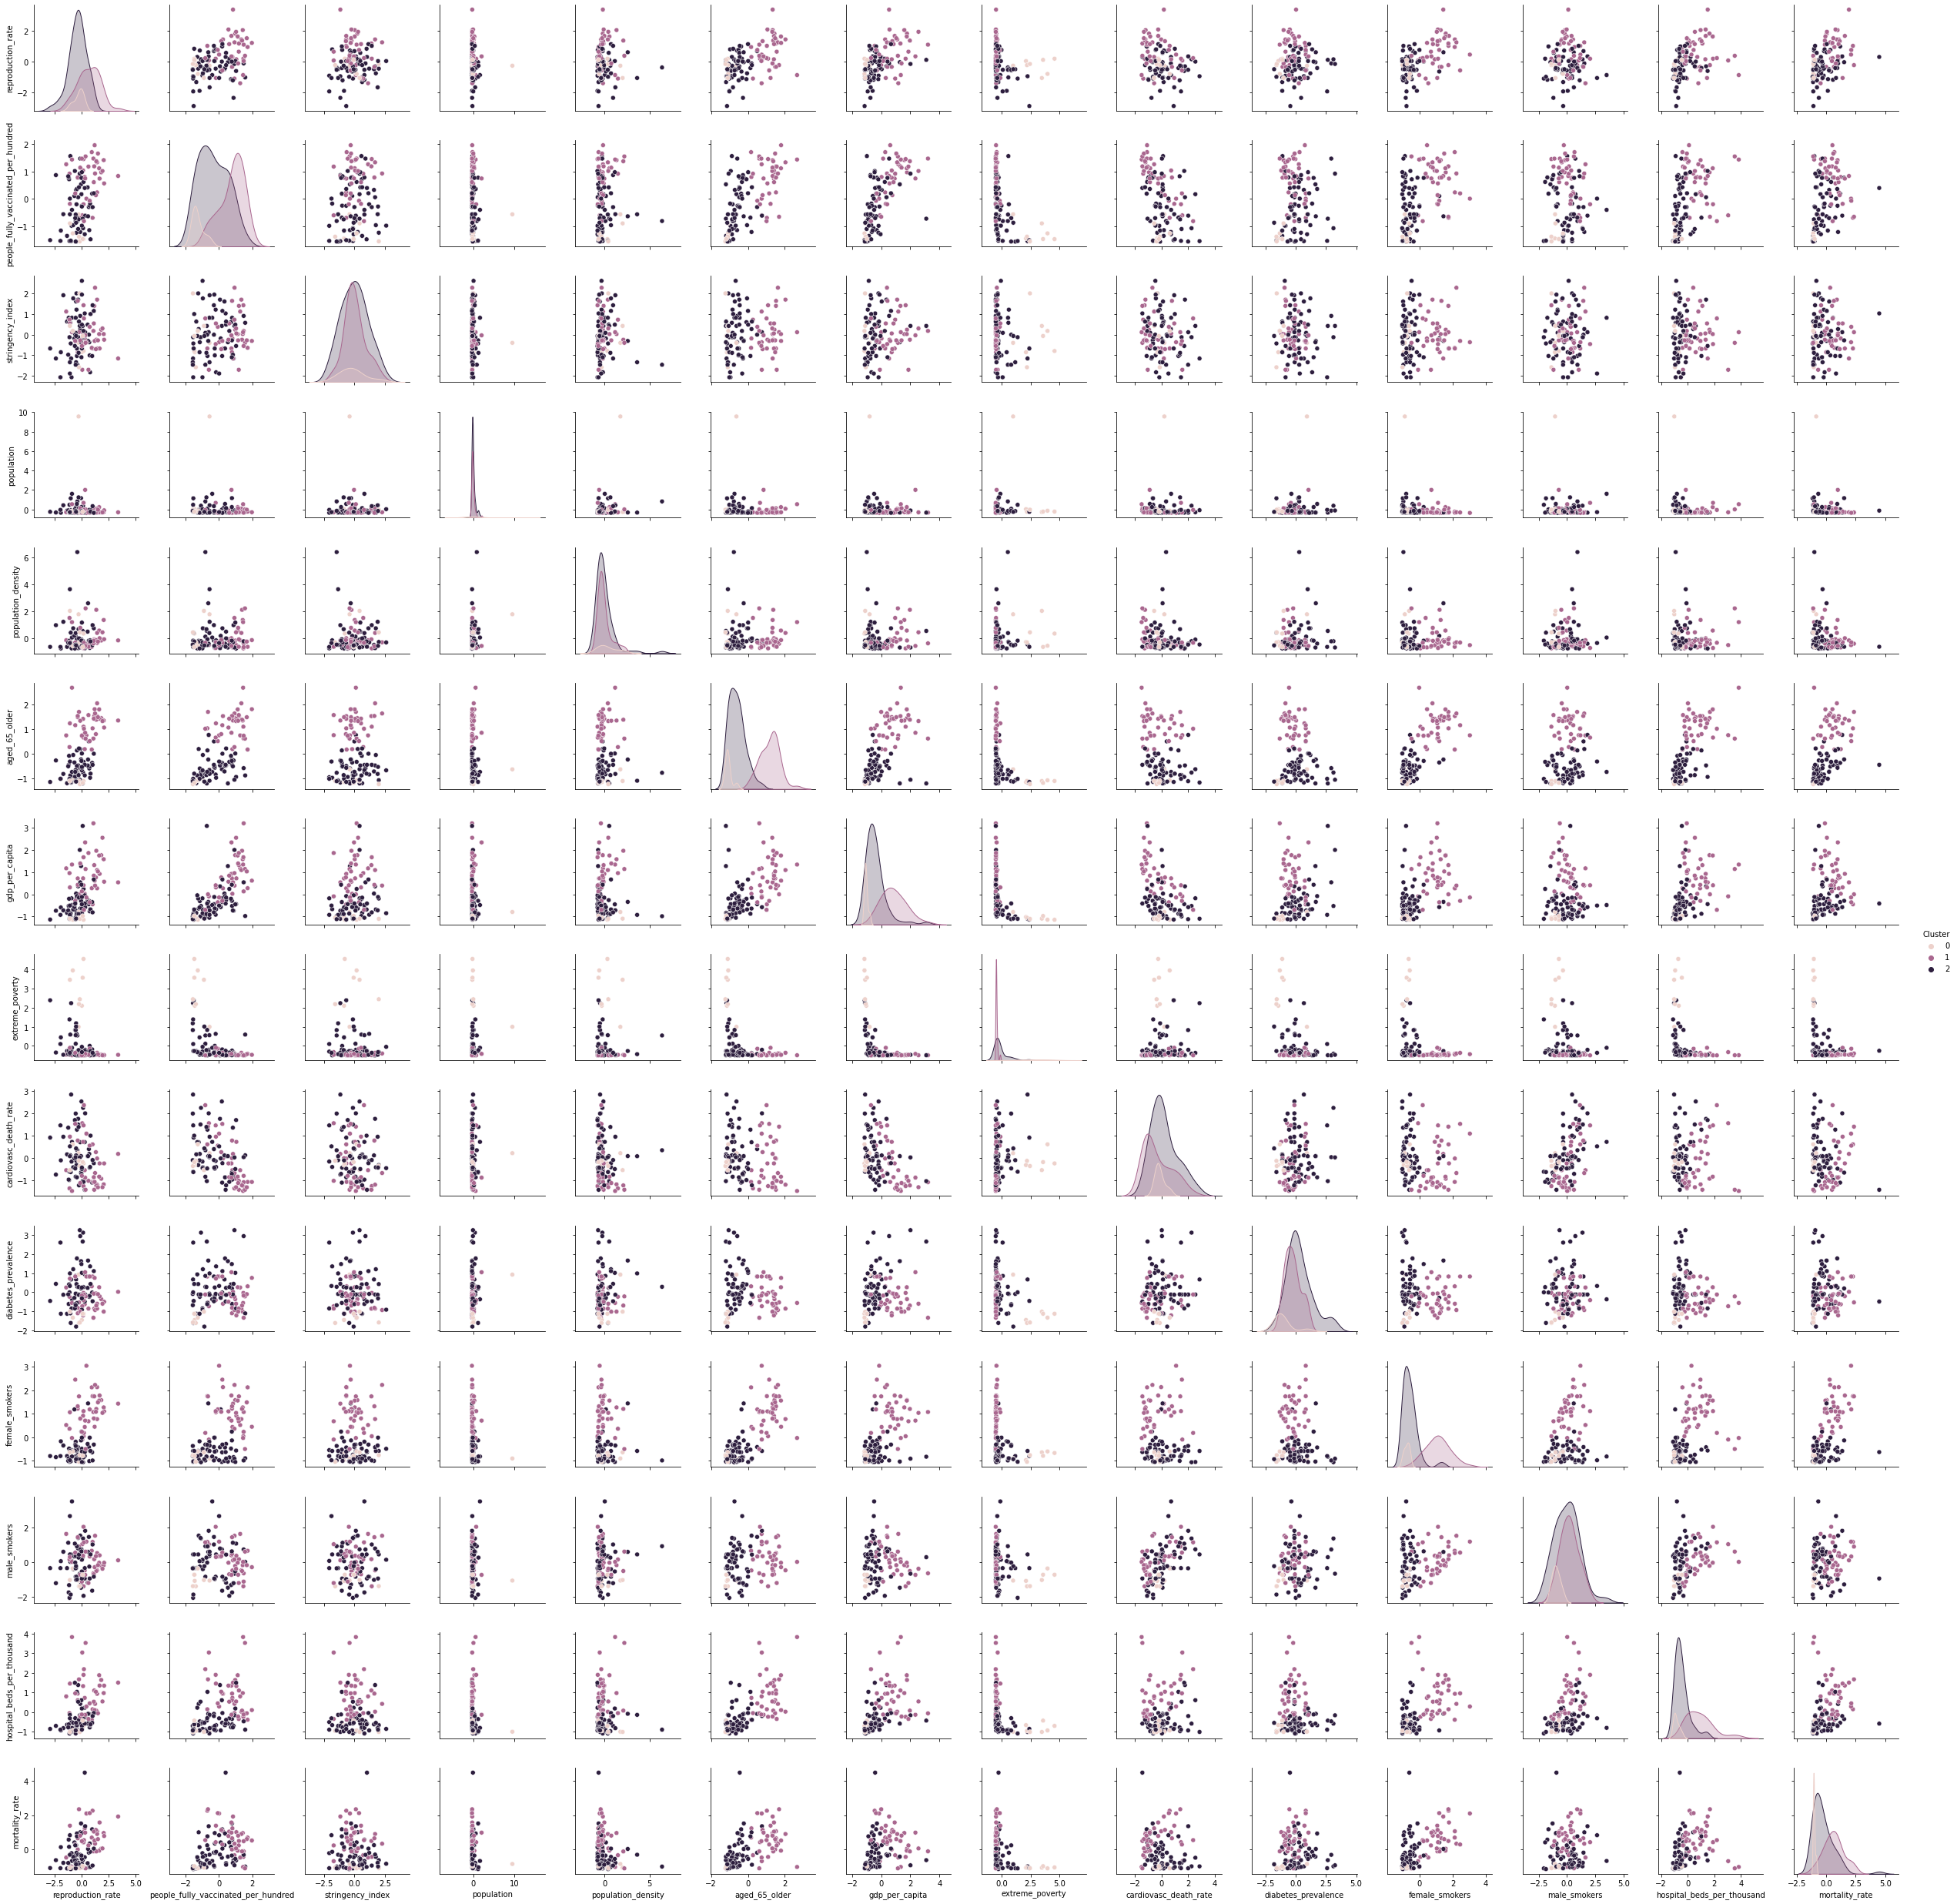

In [ ]:
import seaborn as sns

sns.pairplot(new_df2_scaled, hue='Cluster')
plt.show()

Find countries in each cluster

In [ ]:
countries = df.loc[df['date'] =='2021-11-10']['location'].tolist()
continents = df.loc[df['date'] =='2021-11-10']['continent'].tolist()
codes = df3.loc[df3['date'] =='2021-11-10']['iso_code'].tolist()

In [ ]:
new_df2_scaled['location'] = countries
new_df2_scaled['continent'] = continents
new_df2_scaled['iso_code'] = codes
new_df2_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   reproduction_rate                    111 non-null    float64
 1   people_fully_vaccinated_per_hundred  111 non-null    float64
 2   stringency_index                     111 non-null    float64
 3   population                           111 non-null    float64
 4   population_density                   111 non-null    float64
 5   aged_65_older                        111 non-null    float64
 6   gdp_per_capita                       111 non-null    float64
 7   extreme_poverty                      111 non-null    float64
 8   cardiovasc_death_rate                111 non-null    float64
 9   diabetes_prevalence                  111 non-null    float64
 10  female_smokers                       111 non-null    float64
 11  male_smokers                    

In [ ]:
cluster_0_countries = new_df2_scaled.loc[new_df2_scaled['Cluster'] == 0]['location'].tolist()
cluster_0_continent = new_df2_scaled.loc[new_df2_scaled['Cluster'] == 0]['continent'].tolist()
cluster_1_countries = new_df2_scaled.loc[new_df2_scaled['Cluster'] == 1]['location'].tolist()
cluster_1_continent = new_df2_scaled.loc[new_df2_scaled['Cluster'] == 1]['continent'].tolist()
cluster_2_countries = new_df2_scaled.loc[new_df2_scaled['Cluster'] == 2]['location'].tolist()
cluster_2_continent = new_df2_scaled.loc[new_df2_scaled['Cluster'] == 2]['continent'].tolist()

In [ ]:
print('Cluster 0: ' ,cluster_0_countries)
print('Cluster 1: ' ,cluster_1_countries)
print('Cluster 2: ' ,cluster_2_countries)

Cluster 0:  ['India', 'Kenya', 'Malawi', 'Mozambique', 'Rwanda', 'Senegal', 'Uganda', 'Zambia']
Cluster 1:  ['Argentina', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Canada', 'Chile', 'Croatia', 'Cuba', 'Czechia', 'Estonia', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Lithuania', 'Montenegro', 'Netherlands', 'North Macedonia', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Slovakia', 'Slovenia', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom', 'United States', 'Uruguay']
Cluster 2:  ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Azerbaijan', 'Bangladesh', 'Bolivia', 'Botswana', 'Brazil', 'Cambodia', 'Cameroon', 'Colombia', 'Costa Rica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Ethiopia', 'Georgia', 'Guatemala', 'Honduras', 'Indonesia', 'Iran', 'Iraq', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Lebanon', 'Libya', 'Malays

In [ ]:
from collections import Counter
Counter(cluster_0_continent)


Counter({'Africa': 7, 'Asia': 1})

In [ ]:
Counter(cluster_1_continent)

Counter({'Asia': 3, 'Europe': 31, 'North America': 3, 'South America': 3})

In [ ]:
Counter(cluster_2_continent)

Counter({'Africa': 15,
         'Asia': 29,
         'Europe': 3,
         'North America': 9,
         'South America': 7})

Visualize the clusters on world map

In [ ]:
!pip install --upgrade geopandas

     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 15.4 MB 44.1 MB/s 
     |████████████████████████████████| 6.3 MB 14.1 MB/s 


In [ ]:
import geopandas as gpd
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

print(f"{type(df_world)}, {df_world.geometry.name}")

print(df_world.head())

print(df_world.geometry.geom_type.value_counts())

<class 'geopandas.geodataframe.GeoDataFrame'>, geometry
     pop_est  ...                                           geometry
0     920938  ...  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...
1   53950935  ...  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...
2     603253  ...  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...
3   35623680  ...  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...
4  326625791  ...  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

[5 rows x 6 columns]
Polygon         148
MultiPolygon     29
dtype: int64


In [ ]:
df_world_covid = df_world.merge(new_df2_scaled, how="inner", left_on=['iso_a3'], right_on=['iso_code'])
print("Type of DataFrame : ", type(df_world_covid), df_world_covid.shape[0])

Type of DataFrame :  <class 'geopandas.geodataframe.GeoDataFrame'> 109


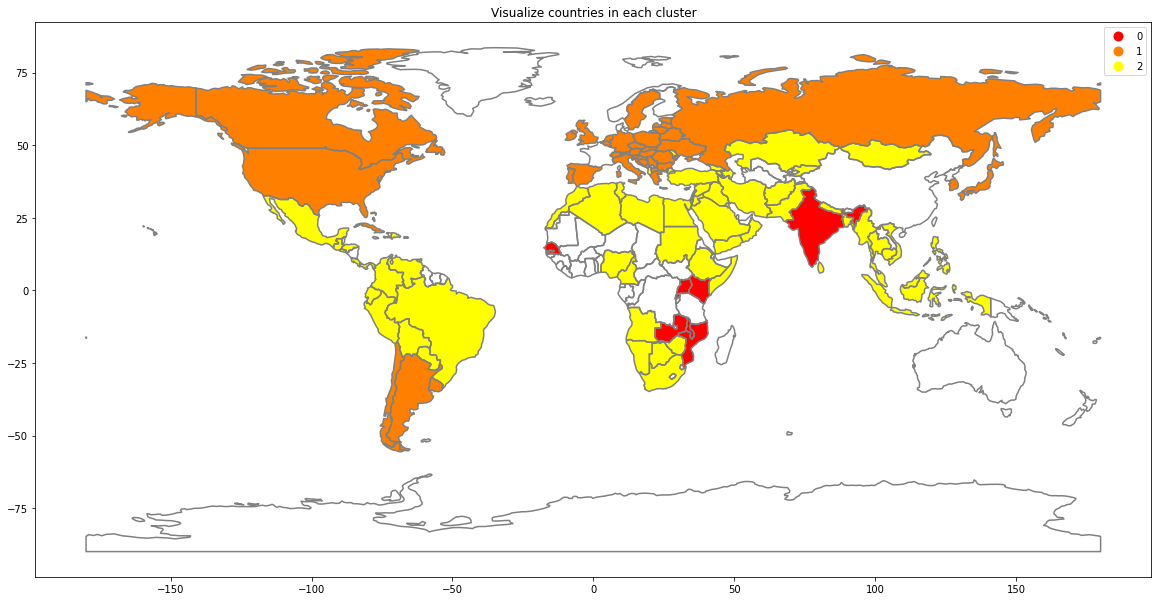

In [ ]:
ax = df_world["geometry"].boundary.plot(figsize=(20,16),color = 'grey')
df_world_covid.plot( column="Cluster", ax=ax, cmap='autumn', categorical=True, legend=True)
ax.set_title("Visualize countries in each cluster")
plt.show()

Time series model ARIMA

Model for cluster 0 

['India', 'Kenya', 'Malawi', 'Mozambique', 'Rwanda', 'Senegal', 'Uganda', 'Zambia']

In [ ]:
#differencing - make stationary
new_cases_diff = [0]
for i in range(1,len(df)):
  if df['location'][i] == df['location'][i-1]:
    new_cases_diff.append(df['new_cases'][i]-df['new_cases'][i-1])
  else:
    new_cases_diff.append(0)

In [ ]:
df['new_cases_diff'] = new_cases_diff

In [ ]:
# Model for cluster 0

df3 = df[df['location'].isin(cluster_0_countries)]
df3_cluster0 = df3[['location','continent','date','new_deaths','new_cases_diff', 'new_cases','reproduction_rate','people_fully_vaccinated_per_hundred',
       'stringency_index', 'population', 'population_density', 'aged_65_older','gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers','hospital_beds_per_thousand']]

In [ ]:
df3_cluster0.tail()

,location,continent,date,new_deaths,new_cases_diff,new_cases,reproduction_rate,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand
28045,Zambia,Africa,2021-11-06,1.0,-20,17,1.02,2.98,44.44,18920657,22.995,2.48,3689.251,57.5,234.499,3.94,3.1,24.7,2.0
28046,Zambia,Africa,2021-11-07,1.0,16,33,1.02,2.98,44.44,18920657,22.995,2.48,3689.251,57.5,234.499,3.94,3.1,24.7,2.0
28047,Zambia,Africa,2021-11-08,0.0,-27,6,1.01,2.98,44.44,18920657,22.995,2.48,3689.251,57.5,234.499,3.94,3.1,24.7,2.0
28048,Zambia,Africa,2021-11-09,0.0,4,10,1.00,2.98,44.44,18920657,22.995,2.48,3689.251,57.5,234.499,3.94,3.1,24.7,2.0
28049,Zambia,Africa,2021-11-10,0.0,11,21,1.00,2.98,44.44,18920657,22.995,2.48,3689.251,57.5,234.499,3.94,3.1,24.7,2.0


In [ ]:
df3_cluster0['date'] = pd.to_datetime(df3_cluster0['date'], infer_datetime_format=True)

In [ ]:
#Create seasonality columns
def create_date_features(df):
    # Since we have converted 'date' column into 'Date Format' we are allowed to use the methods that we see below(like : date.dt.month,day,year etc.) 
    df['month'] = df.date.dt.month # Which month of the corresponding year
    df['day_of_month'] = df.date.dt.day # Which day of the corresponding month
    df['day_of_year'] = df.date.dt.dayofyear # Which day of the corresponding year
    df['week_of_year'] = df.date.dt.weekofyear # Which week of the corresponding year
    df['day_of_week'] = df.date.dt.dayofweek # Which day of the corresponding week of the each month
    df["is_wknd"] = df.date.dt.weekday // 4 # df.date.dt.weekday => Starts from '0' means '0' = 'Monday'. So, '// 4' will give '1' when day number equals
    # to '5'(which corresponds 'Saturday') and '6'(which corresponds 'Sunday') and '0' for rest of them. Consequently this column will represent whether 
    # the day is weekend or not
    df['is_month_start'] = df.date.dt.is_month_start.astype(int) # Is it starting of the corresponding month
    df['is_month_end'] = df.date.dt.is_month_end.astype(int) # Is it ending of the corresponding month
    return df

In [ ]:
df3_cluster0 = create_date_features(df3_cluster0)
df3_cluster0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 9690 to 28049
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   location                             2040 non-null   object        
 1   continent                            2040 non-null   object        
 2   date                                 2040 non-null   datetime64[ns]
 3   new_deaths                           2040 non-null   float64       
 4   new_cases_diff                       2040 non-null   int64         
 5   new_cases                            2040 non-null   int64         
 6   reproduction_rate                    2040 non-null   float64       
 7   people_fully_vaccinated_per_hundred  2040 non-null   float64       
 8   stringency_index                     2040 non-null   float64       
 9   population                           2040 non-null   int64         
 10  populati

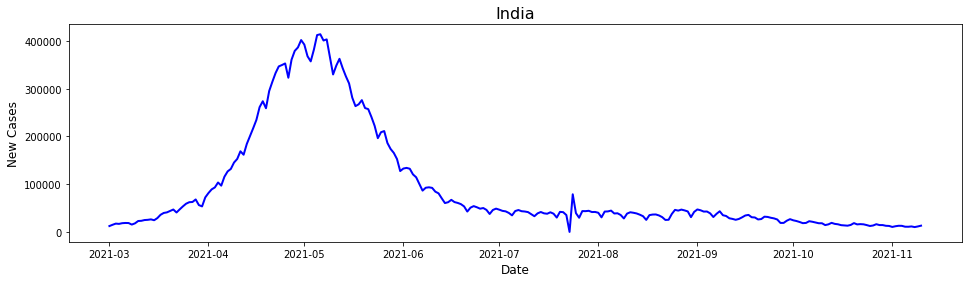

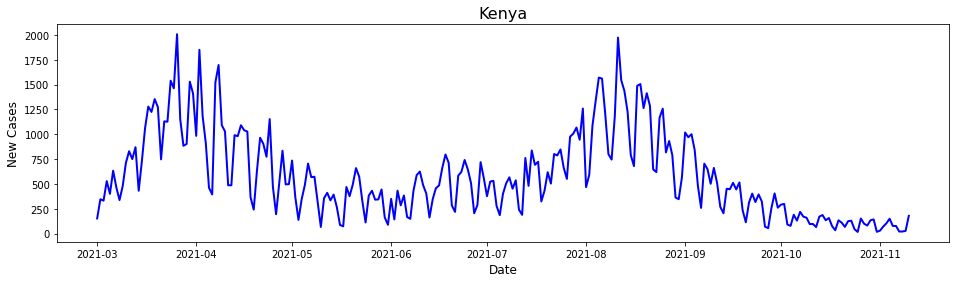

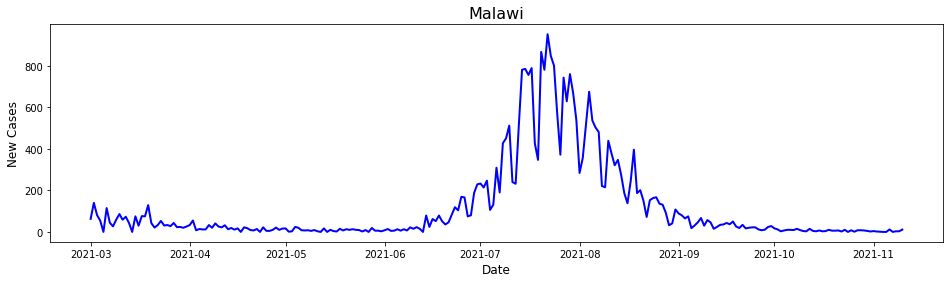

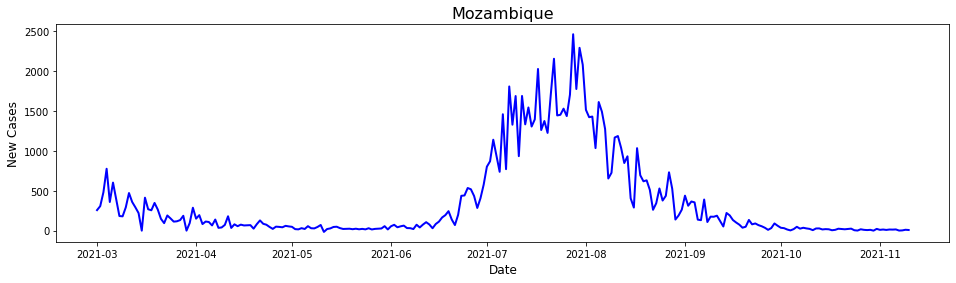

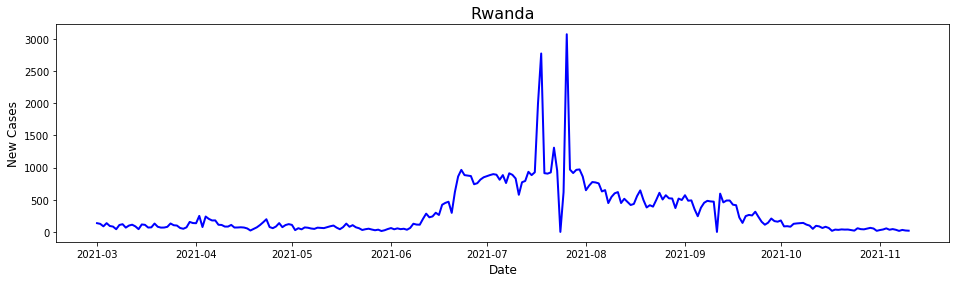

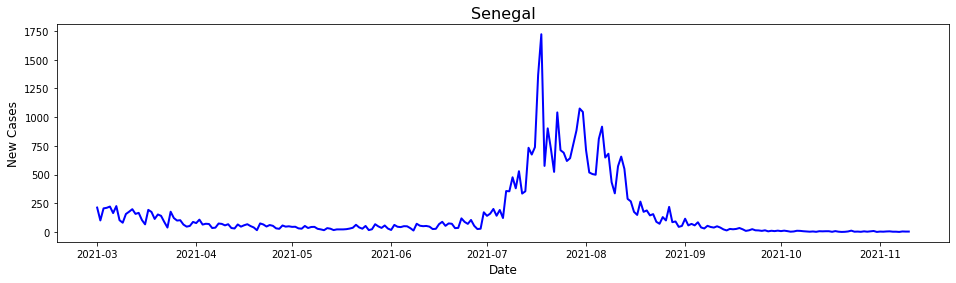

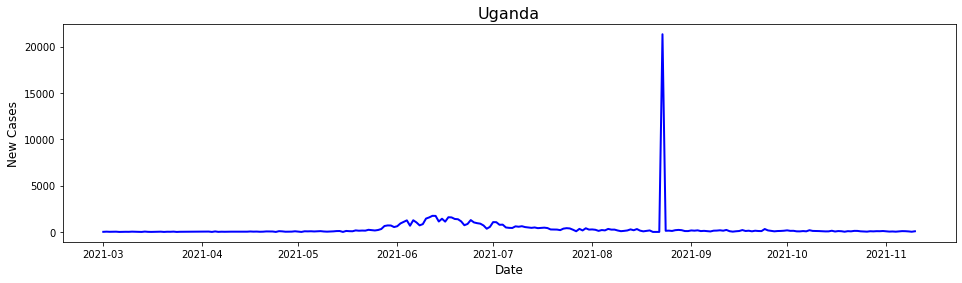

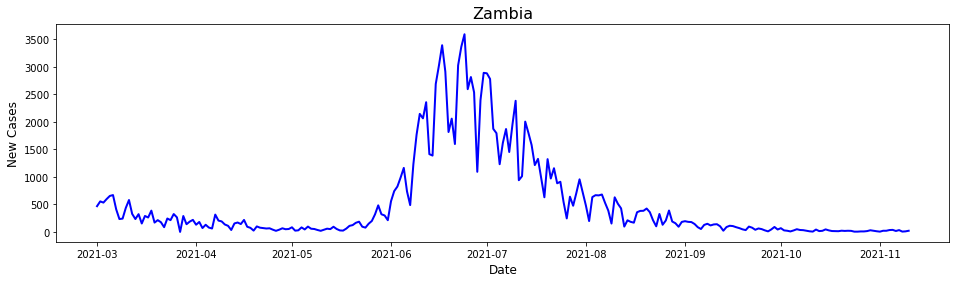

In [ ]:
#before differencing plots
for i in cluster_0_countries:
  x = df3_cluster0.loc[df3_cluster0['location'] == i]['date'].to_numpy()
  y = df3_cluster0.loc[df3_cluster0['location'] == i]['new_cases'].to_numpy()
  plt.figure(figsize=(16, 4))
  plt.plot(x, y, linewidth=2, color='blue')
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('New Cases', fontsize=12)
  plt.title(i,fontsize=16)
  plt.show()

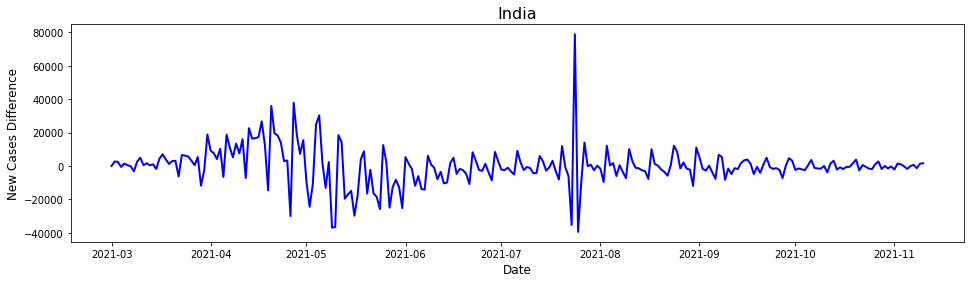

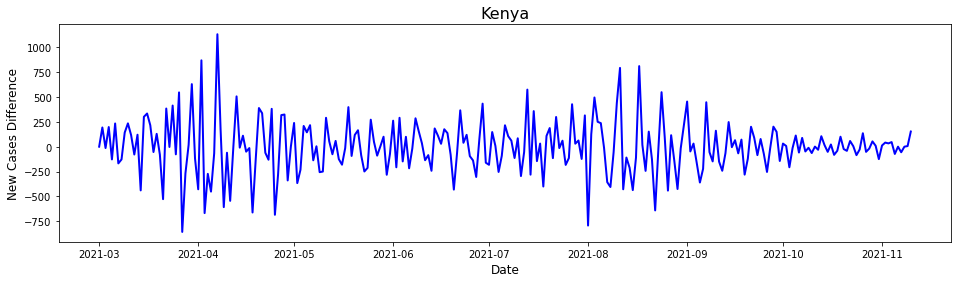

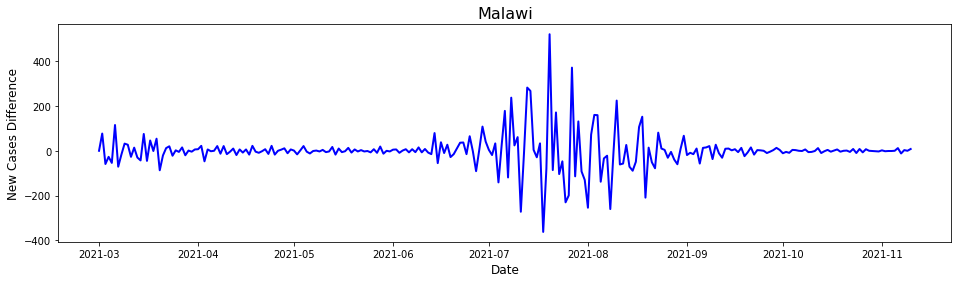

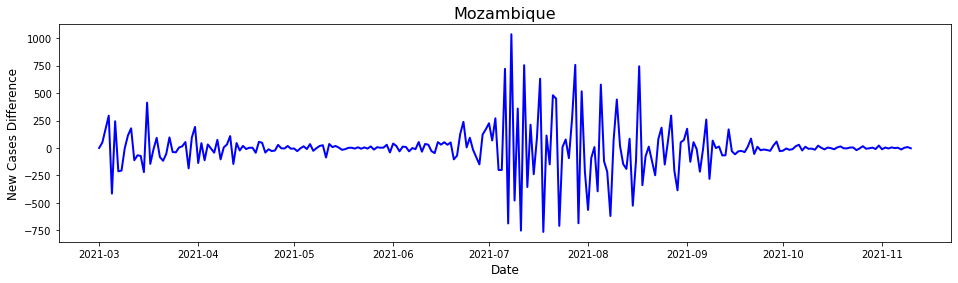

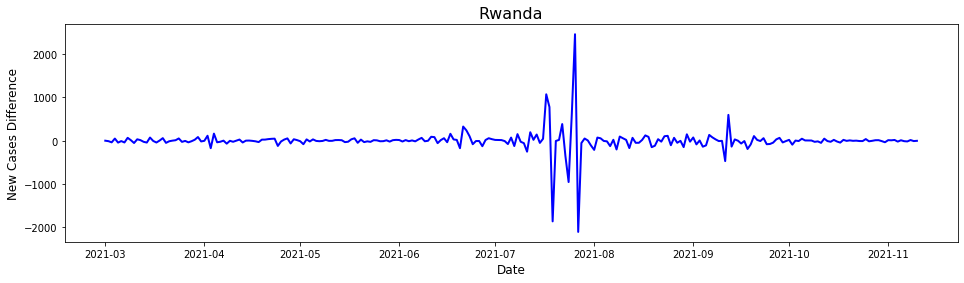

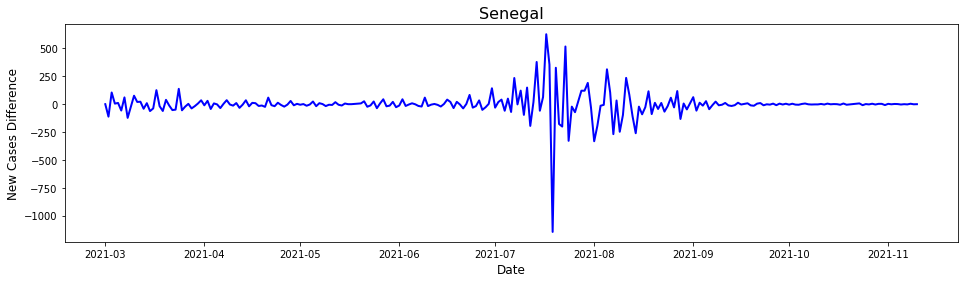

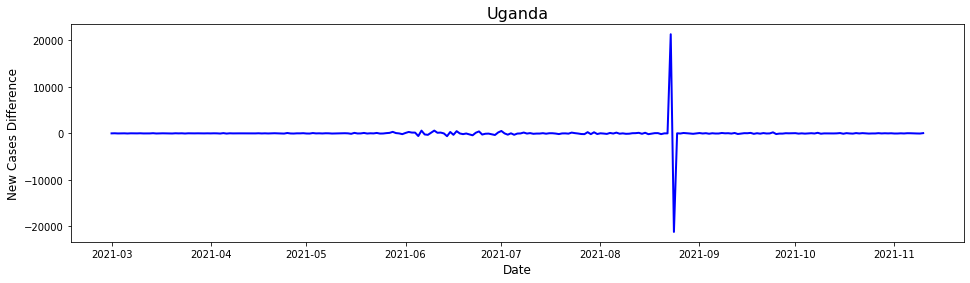

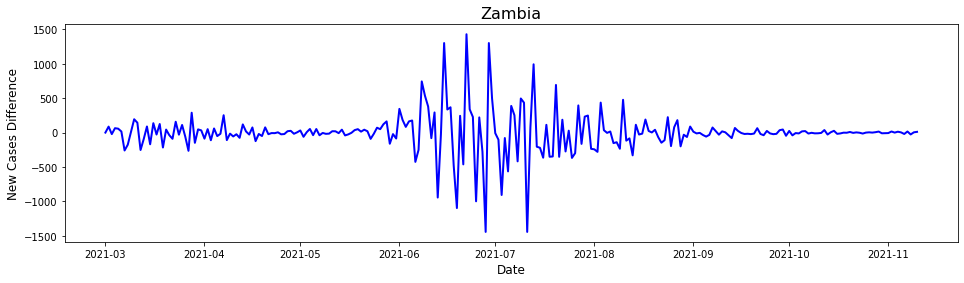

In [ ]:
#after differencing plots
for i in cluster_0_countries:
  x = df3_cluster0.loc[df3_cluster0['location'] == i]['date'].to_numpy()
  y = df3_cluster0.loc[df3_cluster0['location'] == i]['new_cases_diff'].to_numpy()
  plt.figure(figsize=(16, 4))
  plt.plot(x, y, linewidth=2, color='blue')
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('New Cases Difference', fontsize=12)
  plt.title(i,fontsize=16)
  plt.show()

In [ ]:
# Create "Lag/Shifted Features" by using this function
# Since we will create more than 1 "Lag/Shifted Features" I created that function
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['new_deaths_lag_' + str(lag)] = dataframe.groupby(["location"])['new_deaths'].transform(lambda x: x.shift(lag)) 
    return dataframe

In [ ]:
lags_list = [1,2,3,4,5] 
df3_cluster0 = lag_features(df3_cluster0, lags_list) 

In [ ]:
def lag_features_vaccination(dataframe, lags):
    for lag in lags:
        dataframe['people_fully_vaccinated_per_hundred_lag_' + str(lag)] = dataframe.groupby(["location"])['people_fully_vaccinated_per_hundred'].transform(lambda x: x.shift(lag)) 
    return dataframe

In [ ]:
lags_list = [1,2,3,4,5] 
df3_cluster0 = lag_features_vaccination(df3_cluster0, lags_list) 

In [ ]:
def lag_features_cases(dataframe, lags):
    for lag in lags:
        dataframe['new_cases_diff_lag_' + str(lag)] = dataframe.groupby(["location"])['new_cases_diff'].transform(lambda x: x.shift(lag)) 
    return dataframe

In [ ]:
lags_list = [1,2,3,4,5] 
df3_cluster0 = lag_features_cases(df3_cluster0, lags_list) 

In [ ]:
df3_cluster0.columns

Index(['location', 'continent', 'date', 'new_deaths', 'new_cases_diff',
       'new_cases', 'reproduction_rate', 'people_fully_vaccinated_per_hundred',
       'stringency_index', 'population', 'population_density', 'aged_65_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand', 'month', 'day_of_month', 'day_of_year',
       'week_of_year', 'day_of_week', 'is_wknd', 'is_month_start',
       'is_month_end', 'new_deaths_lag_1', 'new_deaths_lag_2',
       'new_deaths_lag_3', 'new_deaths_lag_4', 'new_deaths_lag_5',
       'people_fully_vaccinated_per_hundred_lag_1',
       'people_fully_vaccinated_per_hundred_lag_2',
       'people_fully_vaccinated_per_hundred_lag_3',
       'people_fully_vaccinated_per_hundred_lag_4',
       'people_fully_vaccinated_per_hundred_lag_5', 'new_cases_diff_lag_1',
       'new_cases_diff_lag_2', 'new_cases_diff_lag_3', 'new_cases_diff_lag_4'

In [ ]:
#train-test split
ar_train = df3_cluster0[df3_cluster0['date'] < '2021-09-01']
ar_test = df3_cluster0[df3_cluster0['date'] >= '2021-09-01']

len(ar_train), len(ar_test)

(1472, 568)

In [ ]:
ar_train.columns

Index(['location', 'continent', 'date', 'new_deaths', 'new_cases_diff',
       'new_cases', 'reproduction_rate', 'people_fully_vaccinated_per_hundred',
       'stringency_index', 'population', 'population_density', 'aged_65_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand', 'month', 'day_of_month', 'day_of_year',
       'week_of_year', 'day_of_week', 'is_wknd', 'is_month_start',
       'is_month_end', 'new_deaths_lag_1', 'new_deaths_lag_2',
       'new_deaths_lag_3', 'new_deaths_lag_4', 'new_deaths_lag_5',
       'people_fully_vaccinated_per_hundred_lag_1',
       'people_fully_vaccinated_per_hundred_lag_2',
       'people_fully_vaccinated_per_hundred_lag_3',
       'people_fully_vaccinated_per_hundred_lag_4',
       'people_fully_vaccinated_per_hundred_lag_5', 'new_cases_diff_lag_1',
       'new_cases_diff_lag_2', 'new_cases_diff_lag_3', 'new_cases_diff_lag_4'

In [ ]:
#train model
import statsmodels.formula.api as smf

ar = smf.ols(formula='''new_cases_diff ~ location + continent + new_deaths_lag_1 + new_deaths_lag_2 + new_deaths_lag_3 + new_deaths_lag_4 + 
                new_deaths_lag_5 + people_fully_vaccinated_per_hundred_lag_1 + people_fully_vaccinated_per_hundred_lag_2 + 
                people_fully_vaccinated_per_hundred_lag_3 + people_fully_vaccinated_per_hundred_lag_4 + people_fully_vaccinated_per_hundred_lag_5 +
                new_cases_diff_lag_1 + new_cases_diff_lag_2 + new_cases_diff_lag_3 + new_cases_diff_lag_4 + new_cases_diff_lag_5 + month + day_of_month + day_of_year + week_of_year
                + day_of_week + is_wknd + is_month_start + is_month_end + reproduction_rate + stringency_index + population + population_density
                 + aged_65_older + gdp_per_capita + extreme_poverty + cardiovasc_death_rate + 
                diabetes_prevalence + female_smokers + male_smokers + hospital_beds_per_thousand''', data=ar_train).fit()
print(ar.summary())

                            OLS Regression Results                            
Dep. Variable:         new_cases_diff   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     12.07
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.01e-52
Time:                        18:13:08   Log-Likelihood:                -14033.
No. Observations:                1432   AIC:                         2.813e+04
Df Residuals:                    1400   BIC:                         2.830e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [ ]:
ar2 = smf.ols(formula='''new_cases_diff ~ location + continent + new_cases_diff_lag_2 + new_cases_diff_lag_3  + new_deaths_lag_3 + new_deaths_lag_4 + 
                new_deaths_lag_5 + month + day_of_month + day_of_year + week_of_year
                + day_of_week + is_wknd + is_month_start + is_month_end + reproduction_rate + population_density + aged_65_older + gdp_per_capita + extreme_poverty + cardiovasc_death_rate + 
                diabetes_prevalence + female_smokers + male_smokers + hospital_beds_per_thousand''', data=ar_train).fit()
print(ar2.summary())

                            OLS Regression Results                            
Dep. Variable:         new_cases_diff   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     16.66
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           5.15e-52
Time:                        18:19:08   Log-Likelihood:                -14051.
No. Observations:                1432   AIC:                         2.814e+04
Df Residuals:                    1411   BIC:                         2.825e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [ ]:
y_pred = ar2.predict(ar_train).to_numpy()

In [ ]:
ar_train['location'].value_counts()

Mozambique    184
Malawi        184
Zambia        184
Rwanda        184
Kenya         184
India         184
Senegal       184
Uganda        184
Name: location, dtype: int64

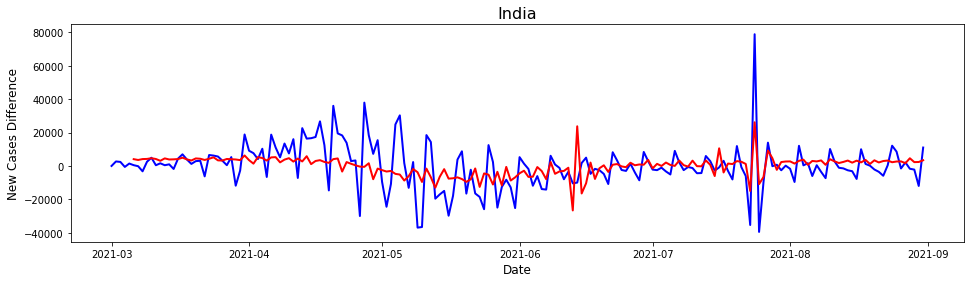

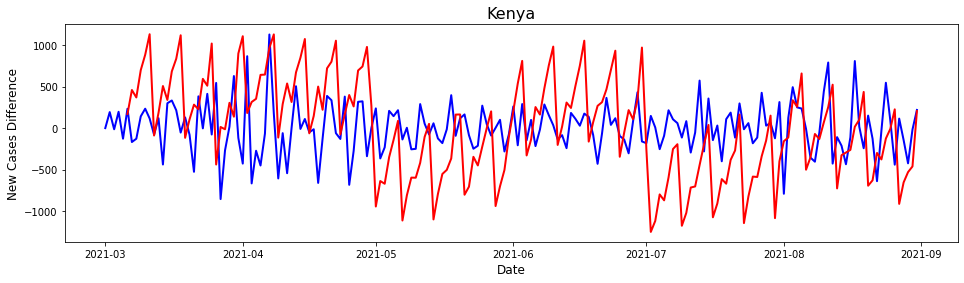

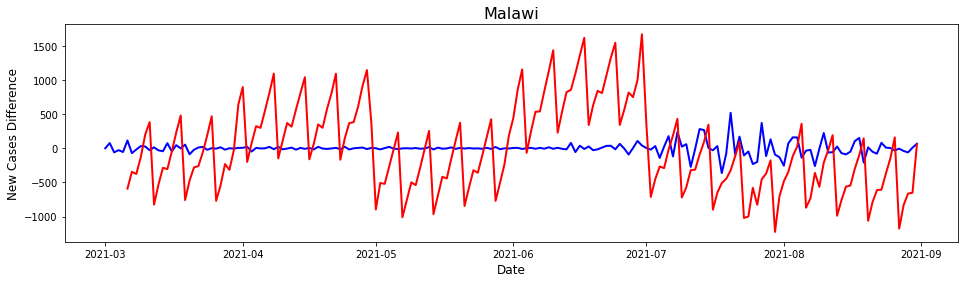

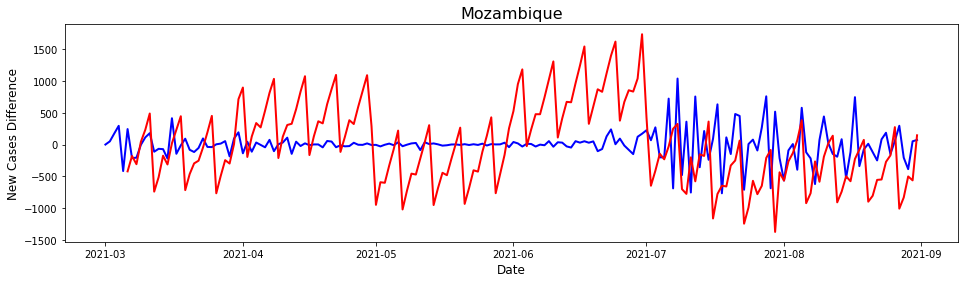

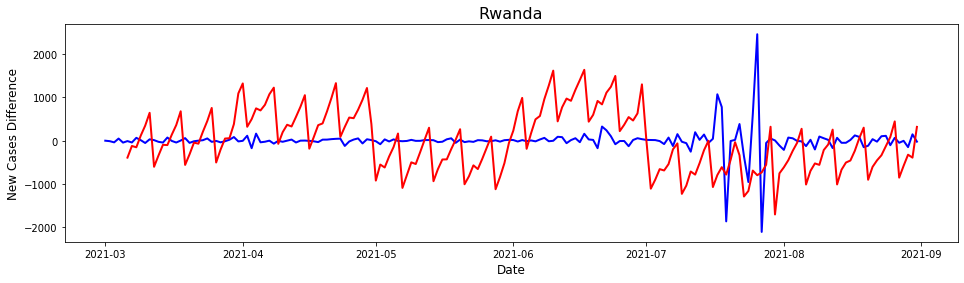

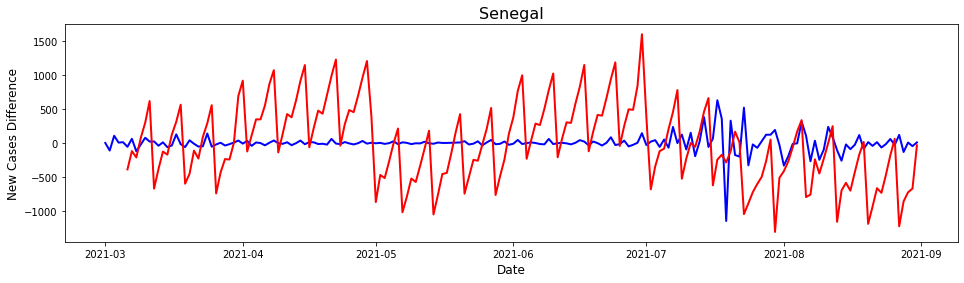

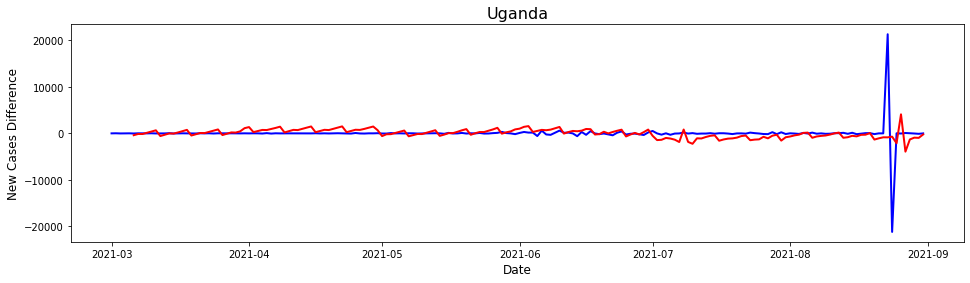

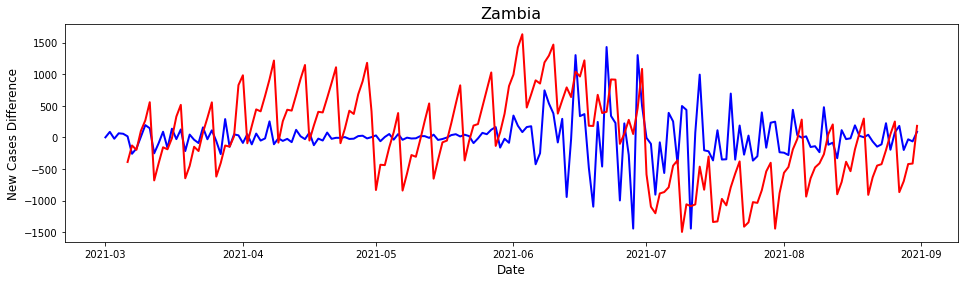

In [ ]:
#each country has 184 rows of time series data
count=[0,184,368,552,736,920,1104,1288,1472]
for i in range(len(cluster_0_countries)):
  x = ar_train.loc[df3_cluster0['location'] == cluster_0_countries[i]]['date'].to_numpy()
  y = ar_train.loc[df3_cluster0['location'] == cluster_0_countries[i]]['new_cases_diff'].to_numpy()
  plt.figure(figsize=(16, 4))
  plt.plot(x, y, linewidth=2, color='blue')
  plt.plot(x,y_pred[count[i]:count[i+1]],linewidth =2, color = 'red')
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('New Cases Difference', fontsize=12)
  plt.title(cluster_0_countries[i],fontsize=16)
  plt.show()

In [ ]:
#predict test set
y_pred_test = ar2.predict(ar_test).to_numpy()

In [ ]:
y_test = ar_test['new_cases_diff']

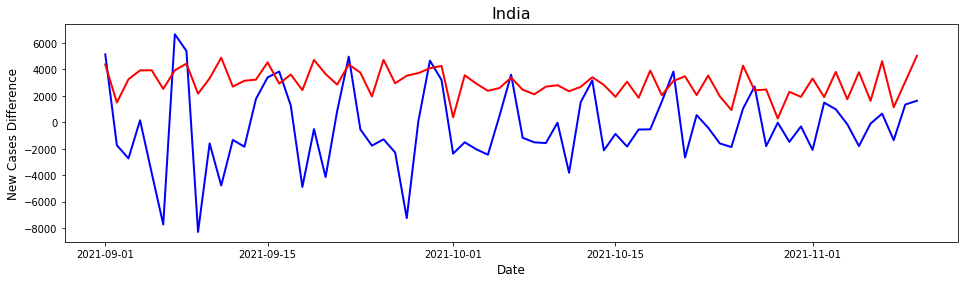

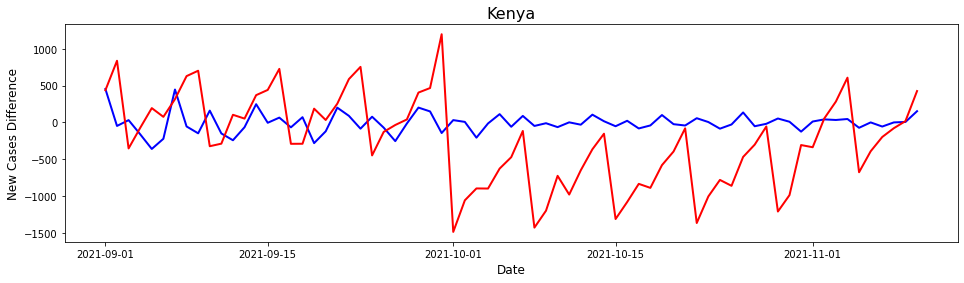

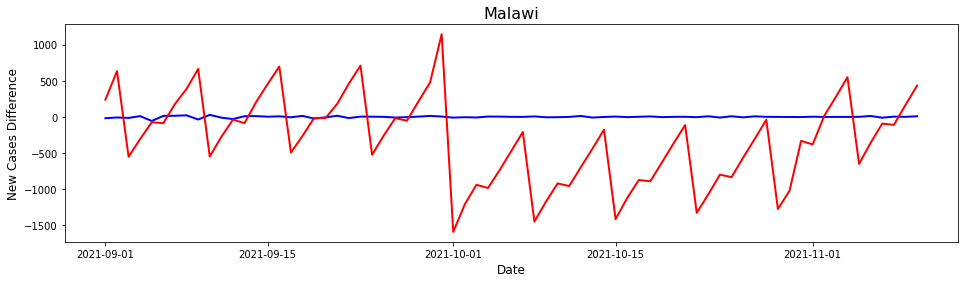

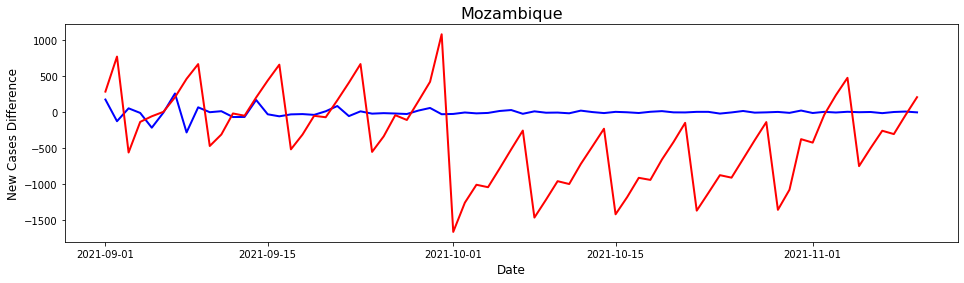

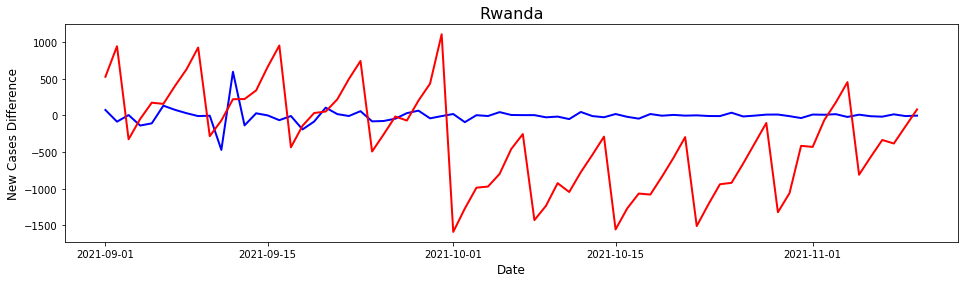

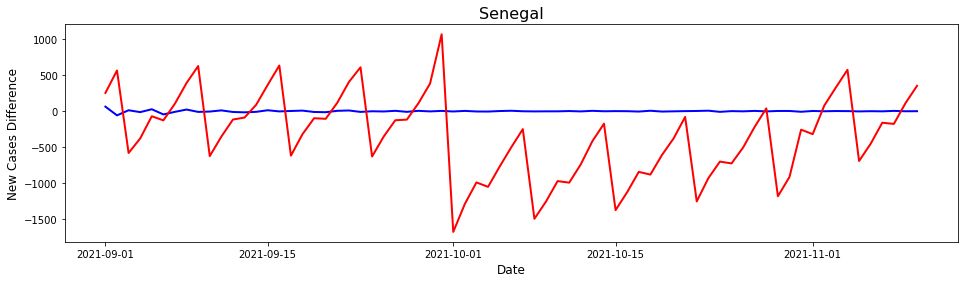

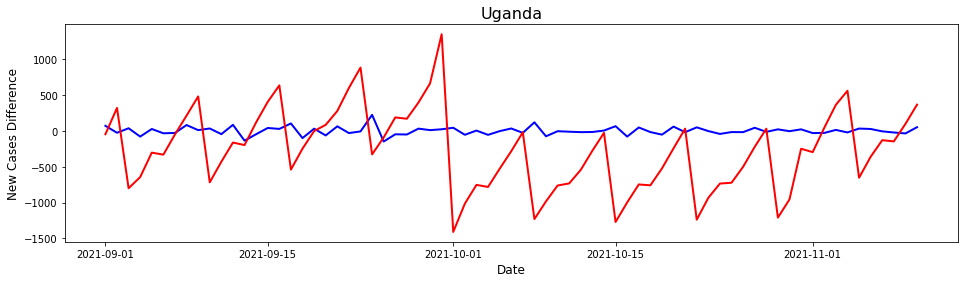

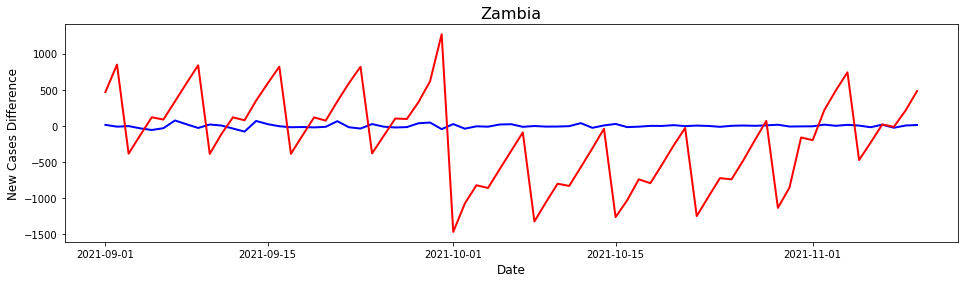

In [ ]:
count=[0,71,142,213,284,355,426,497,568]
for i in range(len(cluster_0_countries)):
  x = ar_test.loc[df3_cluster0['location'] == cluster_0_countries[i]]['date'].to_numpy()
  y = ar_test.loc[df3_cluster0['location'] == cluster_0_countries[i]]['new_cases_diff'].to_numpy()
  plt.figure(figsize=(16, 4))
  plt.plot(x, y, linewidth=2, color='blue')
  plt.plot(x,y_pred_test[count[i]:count[i+1]],linewidth =2, color = 'red')
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('New Cases Difference', fontsize=12)
  plt.title(cluster_0_countries[i],fontsize=16)
  plt.show()


In [ ]:
cols=['location', 'continent', 'date', 'new_deaths', 'new_cases_diff',
       'new_cases', 'reproduction_rate', 'people_fully_vaccinated_per_hundred',
       'stringency_index', 'population', 'population_density', 'aged_65_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand', 'month', 'day_of_month', 'day_of_year',
       'week_of_year', 'day_of_week', 'is_wknd', 'is_month_start',
       'is_month_end', 'new_deaths_lag_1', 'new_deaths_lag_2',
       'new_deaths_lag_3', 'new_deaths_lag_4', 'new_deaths_lag_5',
       'people_fully_vaccinated_per_hundred_lag_1',
       'people_fully_vaccinated_per_hundred_lag_2',
       'people_fully_vaccinated_per_hundred_lag_3',
       'people_fully_vaccinated_per_hundred_lag_4',
       'people_fully_vaccinated_per_hundred_lag_5', 'new_cases_diff_lag_1',
       'new_cases_diff_lag_2', 'new_cases_diff_lag_3', 'new_cases_diff_lag_4',
       'new_cases_diff_lag_5']
X_train_ar = ar_train[cols]
y_train_ar = ar_train['new_cases_diff']

X_test_ar = ar_test[cols]
y_test_ar = ar_test['new_cases_diff']

In [ ]:
SSE = np.sum((y_test_ar - y_pred_test)**2)
SST = np.sum((y_test_ar - np.mean(y_train_ar))**2)             
OSR2 = (1 - SSE/SST)
print('OSR2: ', OSR2)

OSR2:  -1.6076094598446238


In [ ]:
MAE = np.mean(abs(y_test_ar - y_pred_test))
print('Test set MAE: ', MAE)

Test set MAE:  925.9812314126548


In [ ]:
MAE = np.mean(abs(y_train_ar - y_pred))
print('Train set MAE: ', MAE)

Train set MAE:  1605.8035878983383


In [ ]:
RMSE = np.sqrt(np.mean((y_test_ar - y_pred_test)**2))
print('Test set RMSE: ', RMSE)

Test set RMSE:  1681.739432072245


In [ ]:
RMSE = np.sqrt(np.mean((y_train_ar - y_pred)**2))
print('Train set RMSE: ', RMSE)

Train set RMSE:  4415.918733579112
